# Latent News Probability Model

Directly below contains the pip installs that are required for this project. If you run this code and still don't have the required packages, you may need to add a `!pip install [library_name]` into this code block. This does not need to be run every time the model is used. P.S it might be better to run one pip install command at a time, because they can take a long time to run.

IMPORTANT: If you are running this for the first time you may need to download these packages before continuing:

In [1]:
# Dataframe and sentiment analysis
!pip install pandas
!pip install spacy
!pip install spacytextblob
!python -m spacy download en_core_web_sm

# Webscraping
!pip install newspaper3k

# Topic modeling 
!pip install gensim

# Data vis
!pip install plotly
!pip install sklearn
!pip install matplotlib
!pip install wordcloud
!pip install seaborn


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Spacy: Used for NLP and has the machine learning module
    
SpacyTextBlob: Used for the sentiment analysis
    
Pandas: Stores the data as a dataframe table
    
NewsPaper: Used for web scraping

Gensim: Used for topic modeling
    
Requests: Makes the connection to the URL

Plotly: Used for data visualization

Matplotlib: Used for clustering and data visualization

Sklearn: Used for clustering and data visualization

## Start Here: Library Imports

In [ ]:
# Newspaper3k web scraping
from newspaper import Article

from random import shuffle
import re
import requests

from collections import Counter

# Pandas dataframe
import pandas as pd

import numpy as np
import json
import requests
import glob

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary  # Import the Dictionary class from Gensim

# Spacy
import spacy
from nltk.corpus import stopwords
from spacytextblob.spacytextblob import SpacyTextBlob

# Vis
import pyLDAvis
import pyLDAvis.gensim
import plotly.express as px
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import sklearn
from sklearn.manifold import TSNE
from wordcloud import WordCloud
from sklearn.decomposition import PCA
import seaborn as sns



# K-Means Clustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt

# Principled Component Analysis
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

IMPORTANT: Run all helper files. The function logic is stored here, and sorted by the part of the pipeline they support.

In [ ]:
%run SentimentAnalysis.ipynb
%run WebScraper.ipynb
%run PipelineHelpers.ipynb
%run TopicModeling.ipynb
%run DataVisualization.ipynb

c:\Users\Deven\AppData\Local\Programs\Python\Python311\Lib\site-packages\nbformat\__init__.py:93: MissingIDFieldWarning: Code cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and will stop doing so in the future.
  validate(nb)


# General Pipeline Settings, and Pre-Analysis Setup

Below are the customizable settings for all of the analysis and processing parts of the pipeline.

Rerun this any time you make changes to these settings, as they will affect the outcome of certain pipeline steps.

IMPORTANT: The csvFile object should be set to a properly setup csv file of article URLs that you copy-paste into the same directory as the pipeline files (we use the relative path to access the file). The csvFile format is explained in the user manual, but simply it needs one column with the first entry being "Address" and the other entries all being article URLs.

In [ ]:
###
### BELOW IS OUR CUSTOMIZABLE SETTINGS
###

# This is the CSV file that is read in
# This csv file should contain a single column of article urls, with the first entry being "Address"
csv_file = "urls_gabriel_generated.csv"


# WEBSCRAPING SETTINGS
# This is the minimum words that we allow for an article
# (to prevent certain blocked articles or bad data)
word_count_filter = 150

# This is the minimum amount of repeated phrases in a text that we will throw an error for
repeated_phrase_filter = 25

# This is the list of all social media URLs that we BLOCK (anything in this list WILL NOT be scraped)
social_starts_with = ["https://www.youtube.com", "https://youtu.be", "https://www.facebook.com",
                          "https://twitter.com", "https://gettr.com/"]

# When webscraping, will only grab the first url_max URLs (set to -1 to turn off)
url_max = 20

# Used to turn on and off the adjusted labels
label_adjuster_on = True

# TOPIC MODELING SETTINGS
# this will set how our topic modeling is generated: limit to the # of topics,
# # of topics we start at, how many we increment by every step
topic_model_dict = {"topic_limit": 8, "topic_start": 5, "topic_step": 2}


###
### END OF CUSTOMIZABLE SETTINGS
###


# MAIN PIPELINE START

## Sentiment Analysis Pipeline

Below is the start of our pipeline.

Here we create our nlp object and add the pipe to it for sentiment analysis. We then read in our .csv file and convert it to a dataframe to pass in to our sentiment analysis function, and gathers the list of all URLs.

Our main_pipeline_sentiment_analysis() function takes in the list of urls, web scrapes their text, and performs sentiment analysis on them, creating a dataframe of all properly scraped articles and their associated sentiment analysis data.

df is the main dataframe object we store our data in.

In [ ]:
# Loading the nlp pipeline and adding spacytextblob
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('spacytextblob') #This is used in our sentiment analysis

# Using panda to load in our .csv file
# File we are checking
df = pd.read_csv(csv_file)
# Column name we are checking (You can switch this column name to match the csv file)
urls = df["Address"].tolist()

# Trim to only include the first url_max URLs
if url_max > 0:
    urls = urls[0:url_max]

# Here is where we start the sentiment analysis over all articles
df = main_pipeline_sentiment_analysis(urls)

if label_adjuster_on:
    df = label_adjuster(df)


0  Articles Completed
Webscraping failed: Word Count or Repeated Phrase
https://www.bbc.com/news/world-us-canada-55805698
Word count:  39
Repeated phrases:  1


10  Articles Completed
Webscraping failed: Word Count or Repeated Phrase
https://apnews.com/hub/hunter-biden
Word count:  42
Repeated phrases:  1


Webscraping failed: Word Count or Repeated Phrase
https://www.bbc.com/news/world-us-canada-55805698
Word count:  39
Repeated phrases:  1


89.47% of the csv was scraped.
The average sentiment score was: 0.021
The average subjectivity score was: 0.387


# TOPIC MODELING

# Create Topic Model w/ Highest Coherence

Here we create our LDA topic model, article corpus, and topic-level sentiment analysis dictionary.

First we pass in our dataframe df and associated settings. The function will create topic models with varying number of topics, compute the topic coherence score for that number of topics over our articles, and return to us the LDA model that has the highest coherence score. It will display a small graphic showing the topic coherence for each number of topics we tested.

Next we will create our topic-level sentiment analysis dictionary using both our dataframe df and the new LDA_model and corpus we just created. This will give us a dictionary of the averaged sentiment scores for every topic of an article, for all articles.

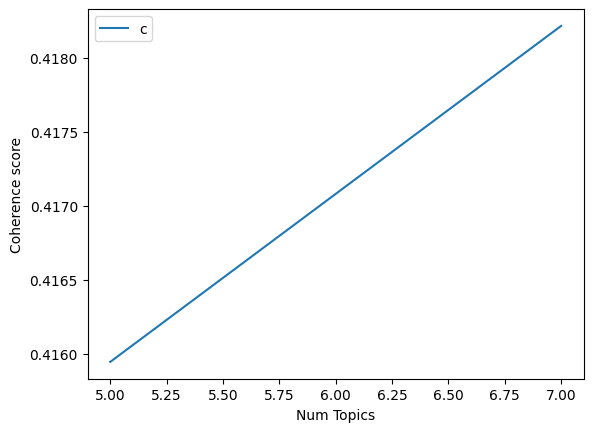

In [ ]:
# This will generate multiple topic models with various topic count, then return
# the model with highest coherence it will also display a quick visual of
# coherence values, to understand what topic count is best and why it was chosen
lda_model, corpus = create_lda_model(topic_model_dict["topic_limit"],
                                     topic_model_dict["topic_start"], 
                                     topic_model_dict["topic_step"])

# lda_model is the lda model we will work with, corpus is the actual corpus of articles we use


# Here we are making our dictionary of all articles and their associated
# topic-level sentiment for every topic
topic_level_sentiment = topic_sentence_sentiment_analysis(df, lda_model)


# DATA VISUALIZATION

## Pre-processing dataframe for visualization

Here we preprocess our dataframe to add in a few relevant columns for data vis, as well as creating our topic relevancy dataframe and weighted sentiment dataframe over all topics for all articles. 

We add the Topics, Main Topic, Main Topic Score, and Shortened Address to the main dataframe (using our preprocess_dataframe_for_datavis() function). This lets the data vis section easily grab the information.

Next we create the topic relevancy dataframe df_topics. In df_topics, each row is an article, and each column is a topic. For an article, every cell value represents the relevancy of that topic to that article. So if row 0 column 1 is 0.998, that means Article 0 has a 0.998 relevancy score on Topic 1.

We create the per_topic_df, which uses our topic-based sentiment dictionary and our topic relevancy dataframe to make a dataframe where each row is an article and each column is a topic. The cell contains data of the form (sentiment, relevancy) which is a tuple that describes the sentiment value and topic relevancy of that article (row) for that topic (column).

In [ ]:
# This generates our dataframe of per-topic sentiment and relevancy for all articles
df_topics = generate_topic_relevancy_dataframe(lda_model)

# Generate our per-topic dataframe
# Format is (SENTIMENT, RELEVANCY)
per_topic_df = create_per_topic_tuple_df(topic_level_sentiment, df_topics)

# This generates a dataframe ready to use with our data visualizations
# (includes some extra information)
# This sorts our dataframe so must go last
df = preprocess_dataframe_for_datavis(df, lda_model, corpus)


## Data Visualization Settings

Here are the customizable settings for our data visualization section. Since these settings only affect how the data will be visualized, you can rerun the pipeline from this point down without rerunning any of the previous steps. This is recommended if you want to see different parameters for the settings visualized on the same data and LDA model.

In [ ]:
# DATA VISUALIZATION SETTINGS
# (starts at topic 0) set this list to every topic number you want
# displayed individually
list_of_topics_to_visualize = [1,2]

# This is the settings dictionary for our k-means cluster generation.
# max_clusters is used in our inertia visualization,
# While num_clusters is our actual cluster count to use and pca_components
# is the PCA component count that we use in both (2 should be used because we reduce to 2 dimensions)
# the visualization of inertia as well as our actual clustering model.
kmeans_settings = {"max_clusters": 10, "num_clusters": 4, "pca_components": 2}



## Display the Main Dataframe and Display the Topic Model

Display the main dataframe

In [ ]:
# display the main dataframe
df

,ID,URL,Article Title,Sentiment Score,Sentiment Label,Subjectivity Score,Positive Words,Negative Words,Text,Topics,Main Topic,Main Topic Score,Associated Words,Shortened Address
0,0,https://www.foxnews.com/politics/hunter-bidens...,Hunter Biden's $250K wire from China labeled a...,0.04,Neutral Positive,0.24,"legal, new, more, first, main, unpaid, best","approximately, previously, firm, limited, down...","exclusive: the $250,000 wire hunter biden rece...","[(2, 0.9974968)]",2,0.997497,"[[wire, say, comer, receive, address, partner,...",www.foxnews.com
1,1,https://www.foxnews.com/politics/doj-ordered-h...,DOJ ordered Hunter Biden investigators to 'rem...,0.06,Neutral Positive,0.35,"wealthy, most, exactly, light, clear, appropri...","subject, criminal, artificially, limited, not,...",the u.s. department of justice ordered fbi and...,"[(3, 0.603655), (4, 0.39470795)]",3,0.603655,"[[say, office, information, attorney, source, ...",www.foxnews.com
2,2,https://www.foxnews.com/politics/hunter-biden-...,"Hunter Biden sues Rudy Giuliani over laptop, a...",-0.04,Negative,0.37,"legal, new, many, first, not, generally, lates...","guilty, hard, past, foreign, infamous, failure...",hunter biden on tuesday filed a lawsuit agains...,"[(6, 0.99759436)]",6,0.997594,"[[drug, president, son, nation, month, get, la...",www.foxnews.com
3,3,https://apnews.com/article/hunter-biden-impeac...,House Republicans make their case for Biden im...,0.02,Neutral,0.37,"clear, legal, right, new, more, promising, hig...","hard, skeptical, criminal, thin, long, expecte...",washington (ap) — house republicans launched a...,"[(4, 0.9983521)]",4,0.998352,"[[say, document, impeachment, hearing, evidenc...",apnews.com
4,4,https://www.nation.com.pk/21-Jun-2023/hunter-b...,Hunter Biden to plead guilty to federal tax ch...,-0.04,Negative,0.44,"important, first, not, social, detailed, love","guilty, subject, criminal, failure, alleged, f...","washigton-hunter biden, the son of president j...","[(3, 0.9946681)]",3,0.994668,"[[say, office, information, attorney, source, ...",www.nation.com.pk
5,5,https://www.nation.com.pk/25-Jul-2021/white-ho...,White House on defensive over Hunter Biden art...,0.10,Positive,0.41,"favorite, winning, appropriate, ethical, new, ...",half,washington - the white house assured saturday ...,"[(0, 0.9941633)]",0,0.994163,"[[say, president, son, buyer, artwork, purchas...",www.nation.com.pk
6,6,https://www.nation.com.pk/24-Dec-2019/hunter-b...,Hunter Biden figures in ‘multiple criminal inv...,-0.11,Negative,0.40,"nearly, new, more","guilty, subject, criminal, allegedly, firm, al...",hunter biden is the subject of multiple crimin...,"[(4, 0.99354595)]",4,0.993546,"[[say, document, impeachment, hearing, evidenc...",www.nation.com.pk
7,7,https://www.cnn.com/2023/09/27/politics/house-...,Hunter Biden probe: House Republicans release ...,-0.01,Neutral Negative,0.35,"general, directly, apparent, light, clear, not...","closed, criminal, single, complained, frustrat...",washington cnn —\ndocuments released wednesday...,"[(4, 0.99821925)]",4,0.998219,"[[say, document, impeachment, hearing, evidenc...",www.cnn.com
8,8,https://abcnews.go.com/Politics/comer-issue-su...,Comer says he will issue subpoenas 'today' for...,0.01,Neutral,0.40,"directly, new, more, first, far, top","mean, previously, extreme, missing, late, other",house oversight committee chairman james comer...,"[(2, 0.10095017), (4, 0.8959267)]",4,0.895927,"[[say, document, impeachment, hearing, evidenc...",abcnews.go.com
9,9,https://apnews.com/article/hunter-biden-prosec...,Hunter Biden prosecutor wasn’t blocked from br...,0.04,Neutral Positive,0.43,"very, special, full, more","closed, subject, no, expected, addicted, behin...",washington (ap) — a second u.s. attorney has t...,"[(3, 0.9945656)]",3,0.994566,"[[say, office, information, attorney, source, ...",apnews.com


Display the topic model words

In [ ]:
# Generate dictionary of all topic words
topic_model_display = create_topic_words_dict(lda_model)

# Display dictionary of all topics and their topic words
topic_model_display

{0: ['say',
  'president',
  'son',
  'buyer',
  'artwork',
  'purchase',
  'year',
  'work',
  'know',
  'target'],
 1: ['say',
  'office',
  'president',
  'family',
  'evidence',
  'son',
  'year',
  'document',
  'receive',
  'information'],
 2: ['wire',
  'say',
  'comer',
  'receive',
  'address',
  'partner',
  'loan',
  'bombshell',
  'beneficiary',
  'news'],
 3: ['say',
  'office',
  'information',
  'attorney',
  'source',
  'charge',
  'foreign',
  'family',
  'relate',
  'son'],
 4: ['say',
  'document',
  'impeachment',
  'hearing',
  'evidence',
  'house',
  'family',
  'president',
  'political',
  'address'],
 5: ['say',
  'president',
  'impeachment',
  'family',
  'office',
  'business',
  'evidence',
  'attorney',
  'tell',
  'son'],
 6: ['drug',
  'president',
  'son',
  'nation',
  'month',
  'get',
  'laptop',
  'use',
  'father',
  'crack']}

## Visualize all articles on their main topic

Here we will show two simple graphs plotting all articles' sentiment values, with the articles sorted by main topic. This is to show the distribution of sentiment towards the different topics. The scatter plot will let you look each article individually, to see how each article contributes to the sentiment distribution. The box plot will show you the actual sentiment distribution for each topic, andgive details on the variance and average sentiment of a topic.

In [ ]:
visualize_all_articles_on_main_topic(df)
visualize_all_articles_on_main_topic(df, plot_type="box")

## Generating 2D and 3D Cluster Graphs of Topics (T-SNE)

This visualization generates a 2D clustering graph representing each article as a point in the topic space, which uses t-SNE dimensionality reduction and clustering. The goal of this visualization is to show every article compared to each other by their similarity in topics. You should see clusters of articles that share a lot of topic words and overall themes, while articles that differ in their topics are shown far apart. Colored by an article's main topic.

In [ ]:
visualize_topic_cluster_tsne(lda_model, df)

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 17 samples in 0.000s...
[t-SNE] Computed neighbors for 17 samples in 0.253s...
[t-SNE] Computed conditional probabilities for sample 17 / 17
[t-SNE] Mean sigma: 0.333712
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.363495
[t-SNE] KL divergence after 1000 iterations: 0.105411


This generates a 3D clustering graph where the x and y-axis represent each article in the topic space, and the z-axis shows the sentiment value for each article. The 2D xy-plane is exactly the same as the 2D graph generated above, but we add a 3rd dimension in the form of sentiment to show how article clusters differ by their sentiment value as well as their topics. Colored by main topic.

In [ ]:
visualize_topic_cluster_tsne_3d(lda_model, df)

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 17 samples in 0.001s...
[t-SNE] Computed neighbors for 17 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 17 / 17
[t-SNE] Mean sigma: 0.333712
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.363495
[t-SNE] KL divergence after 1000 iterations: 0.105411


## Subjectivity vs Sentiment of Articles for a single topic

Will iterate through our list_of_topics_to_visualize and will make a graph for each topic number in that list as well as that topic's word cloud of the top 10 topic words for that topic. So for each topic we want to look at, it will show all the articles with that topic as their main topic, and plot the articles on their subjectivity vs sentiment. A higher subjectivity will show you that the author chose more opinionated words, rather than relying on neutral, factual statements. Compare that with the sentiment value to show whether they are positive and negative towards that topic, and how factual vs. opinionated their claims were. The word cloud will simply tell you what words are in that topic.

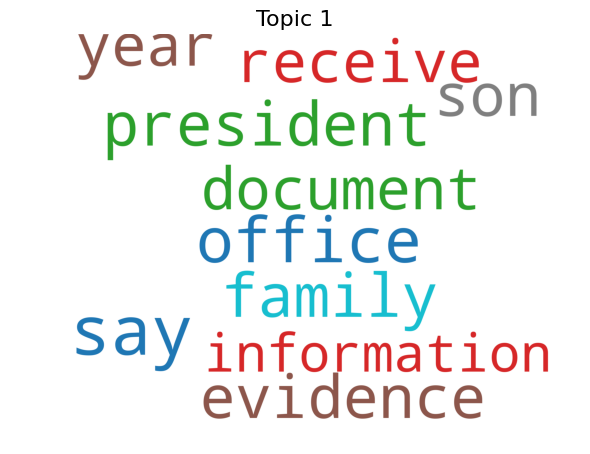

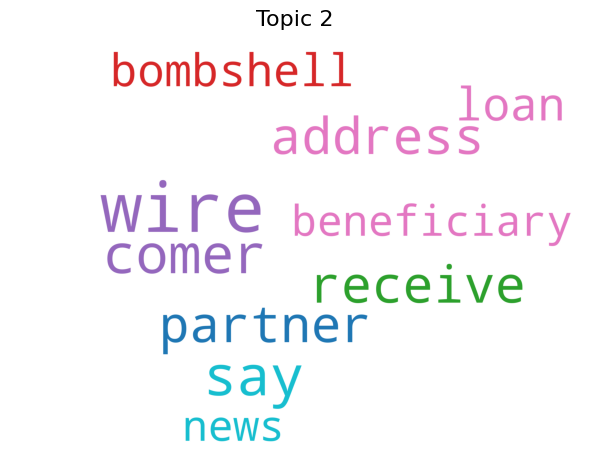

In [ ]:
# Using our list_of_topics_to_visualize list in the customizable settings, 
# produce a graph for each topic
for topic_id in list_of_topics_to_visualize:
    if topic_id <= len(lda_model.print_topics()) - 1:
        visualize_single_topic_subjectivity_vs_sentiment(df, topic_id)
        visualize_topic_word_cloud(lda_model, topic_id)
    else:
        print("Error, topic_id {0} not availible".format(topic_id))


## Generating 2D and 3D Cluster Graphs of Topics (K means Clustering)

Generate a visual of number of topic clusters vs inertia (WCSS score) of the model (low inertia is good). We want to find the optimal number of topic clusters to use, and you can use the "elbow method" on this graph to find it. Ideally, the number of clusters is as small as possible and the inertia is also as small as possible. So to find the point where increasing the number of clusters gives diminishing returns on the inertia score, we imagine the line graph as an arm and use the number of clusters at the "elbow", or the point on the graph where the slope becomes much closer to 0 than the point before.

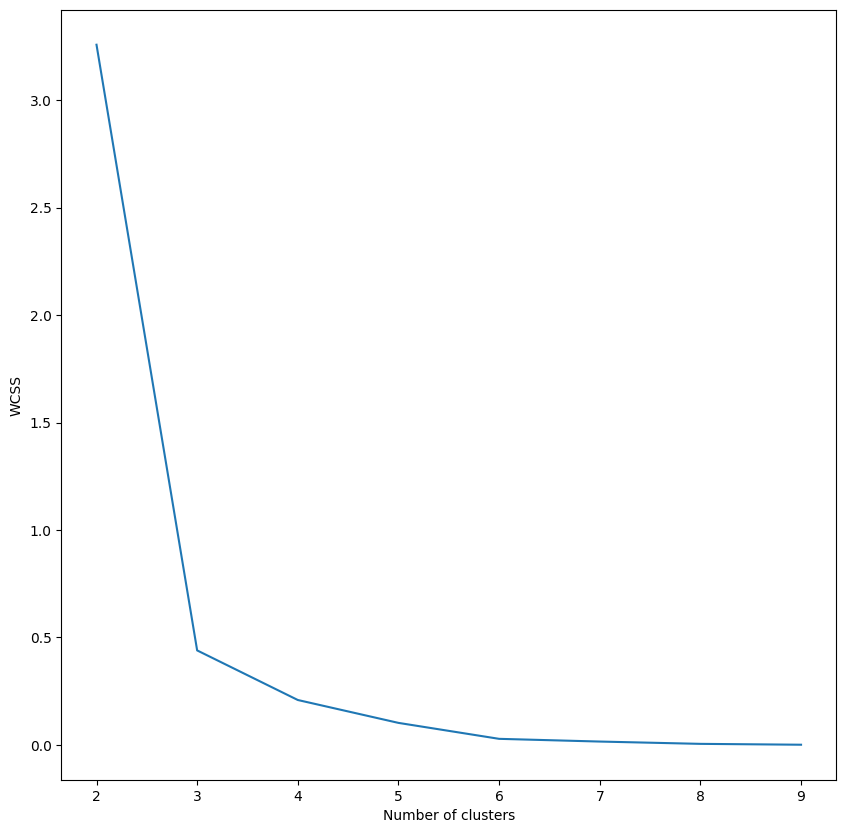

In [ ]:
visualize_optimal_cluster_count(df_topics= df_topics,
                                max_clusters= kmeans_settings["max_clusters"],
                                pca_components= kmeans_settings["pca_components"])


This will generate the topic space in 2D with every article represented as a single point. Very similar to the t-SNE clustering graph, this visualization has the same goal: show topic clusters of articles that are very similar in topic and overall theme. Points closer together means they have very similar topics, while points further apart will be less related. This visualization uses the relevance of each topic to an article as the data behind the clustering. Articles are colored by the user-selected number of clusters (not by main topic).

In [ ]:
visualize_kmeans_clustering(dataframe = df,
                            df_topics= df_topics,
                            num_clusters = kmeans_settings["num_clusters"],
                            pca_components = kmeans_settings["pca_components"])


This visualization is a 3D version of the one above, with a 3rd dimension added to represent sentiment value of each article. So the 2D xy-plane will be exactly the same as the visualization above--meant to represent articles in the topic space and how they are related by topic. The third dimension will show every article's sentiment value, to show how clusters or individual articles differ by sentiment (or are closely related!)

In [ ]:
visualize_kmeans_clustering_3d(dataframe = df,
                                      df_topics= df_topics,
                                      num_clusters = kmeans_settings["num_clusters"],
                                      pca_components = kmeans_settings["pca_components"])

## Relevance X Sentiment of Articles K-MEANS

This visualization is a 2D clustering (using k-means) of the sentiment-weighted topic relevance values of every article. By that, we mean we have the relevance values of each article for every topic. We multiply each of those relevance values by that topic's associated sentiment value for an article, giving us a weighted relevance value based on the sentiment of that article towards that topic.

With that information, we use the same clustering algorithm as the 2D k-means graph above to produce a 2D topic space for every article, but this time it is weighted by the article's sentiment towards the topics.

In [ ]:
# Gather weighted sentiment values into a dataframe
result = multiply_tuples_in_dataframe(per_topic_df)

visualize_kmeans_clustering(dataframe = df,
                            df_topics= result,
                            num_clusters = kmeans_settings["num_clusters"],
                            pca_components = kmeans_settings["pca_components"])


# Sentiment VS Relevance Per Topic

A scatter plot of sentiment values against relevance values of each selected topic. This will display a scatter plot with sentiment values on the x-axis and relevance values on the y-axis, along with a tooltip. 

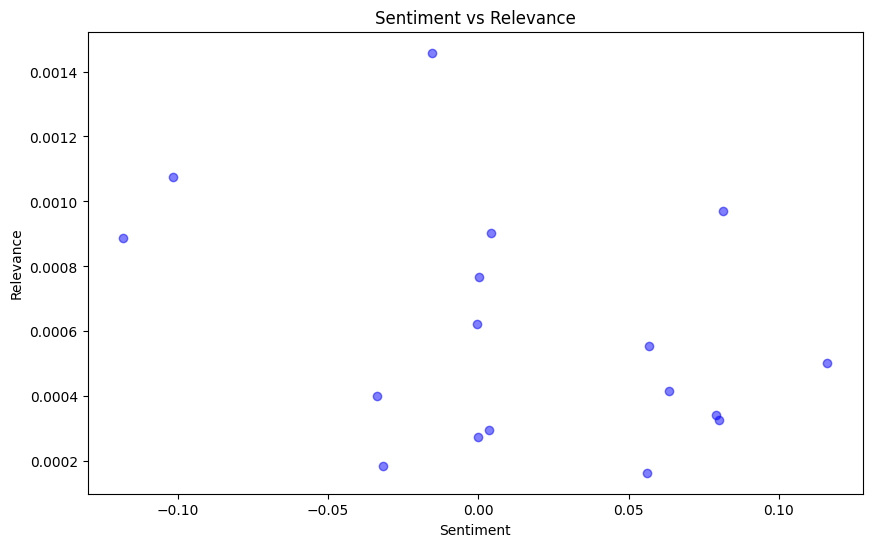

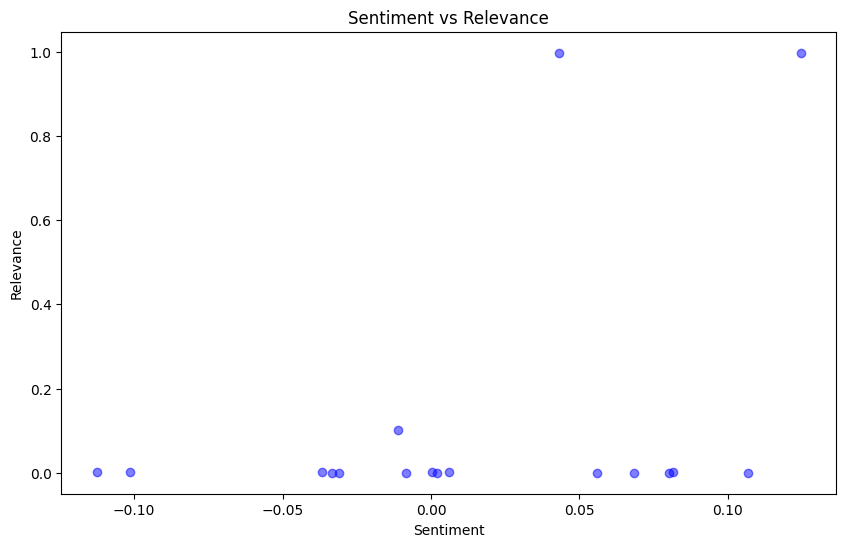

In [ ]:
for topic_id in list_of_topics_to_visualize:
    plot_sentiment_relevance(per_topic_df[:][topic_id])

# Topic Space

Applying principle component analysis(PCA) will reduce the high dimensional topic space into a simple two dimensional space. 2 dimensions is easy for us to interpret but also hold alot of information.

In [ ]:
topic_space = dimension_reduction(df_topics)

Visualize the topic space after principle component analysis(PCA) is applied to reduce the topic model results to two dimensions. Plots each point in the topic space, the distance is directly related to how similar the topics are to each other. This will expose any outlier topics as well as topics that might be quite similar. The ideal plot is one where topics are equal distance from each other.

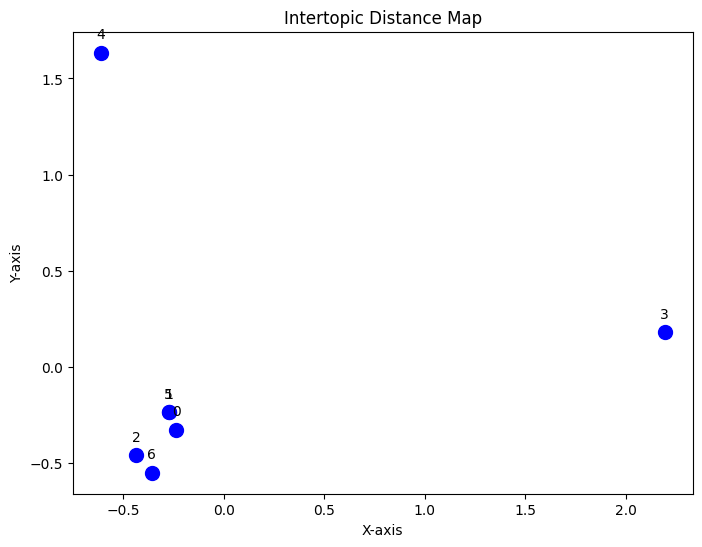

In [ ]:
plot_pca(topic_space)

# Document Sentiment in Topic Space

Here is where each document is added to the topic space, the documents are closer or further from each topic based on the relavence score given to each document. Then a color is added to each document to represent the sentiment score. Red represents a negative sentiment while green represents a positive sentiment.

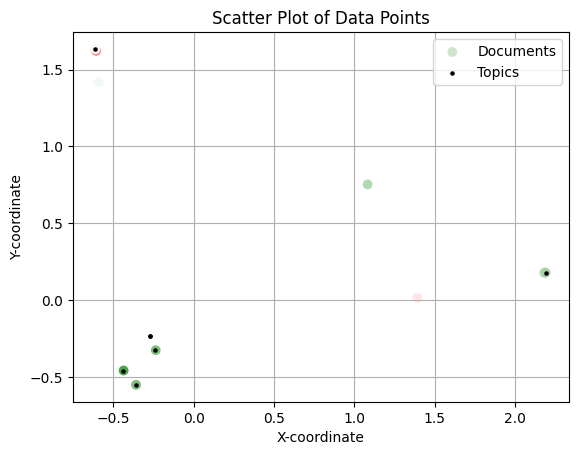

In [ ]:
plot_documents(df_topics, topic_space, df)

# Document Density in Topic Space

This plots the density of documents that were plotted in the topic space. Red is hot zones where many documents fall while white is where very little documents show up. This will help understand the topics that the majority of the articles are covering.

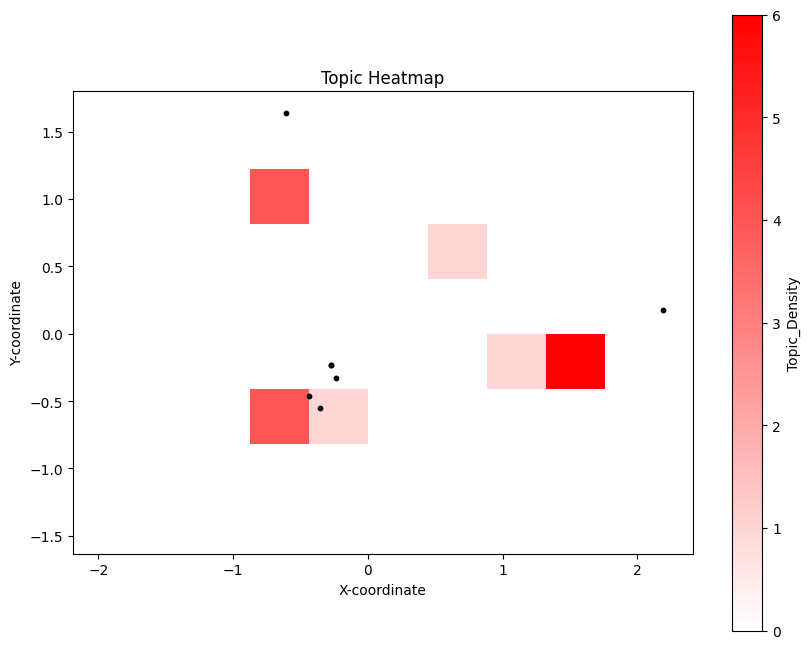

In [ ]:
plot_topic_heatmap(df_topics, topic_space)

# Sentiment Sum Heatmap in Topic Space

This graph plots the normalized sentiment in each area of the topic space. Green being the more positive topics, while red is more negative. Each documents sentiment is added to the area of the heatmap and then normalized to be able to visualize where the positive and negative topics lie in the topic space more easily.

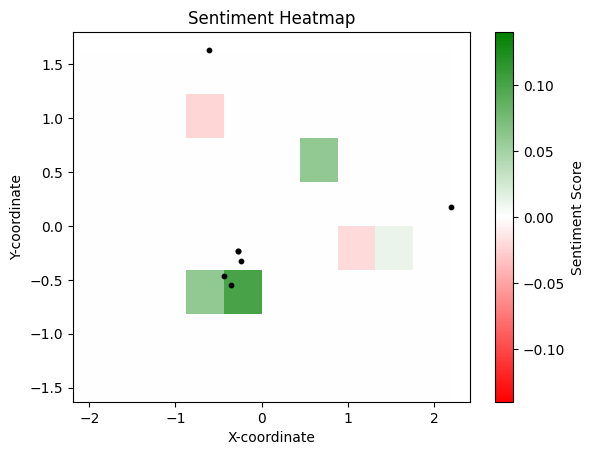

In [ ]:
plot_sentiment_heatmap(df_topics, topic_space, df)